To model it as a Grover Search problem, I would take 3 clauses, since in this case there are three expressions that
"and" symbols, (which might also have inner and symbols but okay), also, since I can do a not in quantum computing 
(X gate) and also 'and' using Toffoli gates, I will convert all the or gates into a combination of not and and gates. 

The 5 bits can be represented as 5 qubits, and the outputs of the three clauses are stored in three clause qubits, so that only when all of them are 1, will the bits be a solution. There will also be a check qubit, which stores an and of all the clause qubits, to check if they are all 1. However, it will be initialised to |->, to generate phase kickback and introduce a negative sign if x is a solution, which is what Grovers algorithm needs.

This is what Grovers oracle is supposed to do, introduce a negative sign infront of the solution qubits, thus changing the amplitude and leading to the algorithm dramatically increasing the magnitude.

NOT -> X gate

AND -> Toffoli

OR -> Convert to AND and NOT by De Morgans Theorem


In [5]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

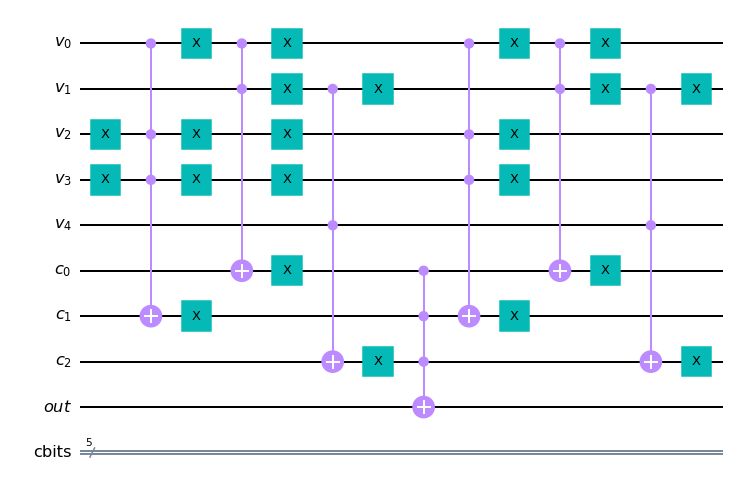

In [17]:
var_qubits = QuantumRegister(5, name='v') # for the 5 variables
clause_qubits = QuantumRegister(3, name='c') # for the 3 clauses
output_qubit = QuantumRegister(1, name='out') # for the final output, multi toffoli of the clauses
cbits = ClassicalRegister(5, name='cbits') # Measuring the variable
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def grover_oracle(qc, clause_qubits):
    # Compute clauses
    """i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1"""
    qc.x(var_qubits[2:4])
    qc.mct([var_qubits[0],var_qubits[2],var_qubits[3]],clause_qubits[1])
    qc.x(var_qubits[2:4])
    qc.x(var_qubits[0])
    qc.ccx(var_qubits[0],var_qubits[1],clause_qubits[0])
    qc.x(var_qubits[0])
    qc.x(var_qubits[1])
    qc.ccx(var_qubits[1],var_qubits[4],clause_qubits[2])
    qc.x(var_qubits[1])
    qc.x(clause_qubits)

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    qc.x(var_qubits[2:4])
    qc.mct([var_qubits[0],var_qubits[2],var_qubits[3]],clause_qubits[1])
    qc.x(var_qubits[2:4])
    qc.x(var_qubits[0])
    qc.ccx(var_qubits[0],var_qubits[1],clause_qubits[0])
    qc.x(var_qubits[0])
    qc.x(var_qubits[1])
    qc.ccx(var_qubits[1],var_qubits[4],clause_qubits[2])
    qc.x(var_qubits[1])
    qc.x(clause_qubits)

grover_oracle(qc, clause_qubits)
qc.draw('mpl')

In [21]:
#Diffuser is used to rotate about the vector |s>, by the following transformations:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate (Rotate about |11..1>)
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

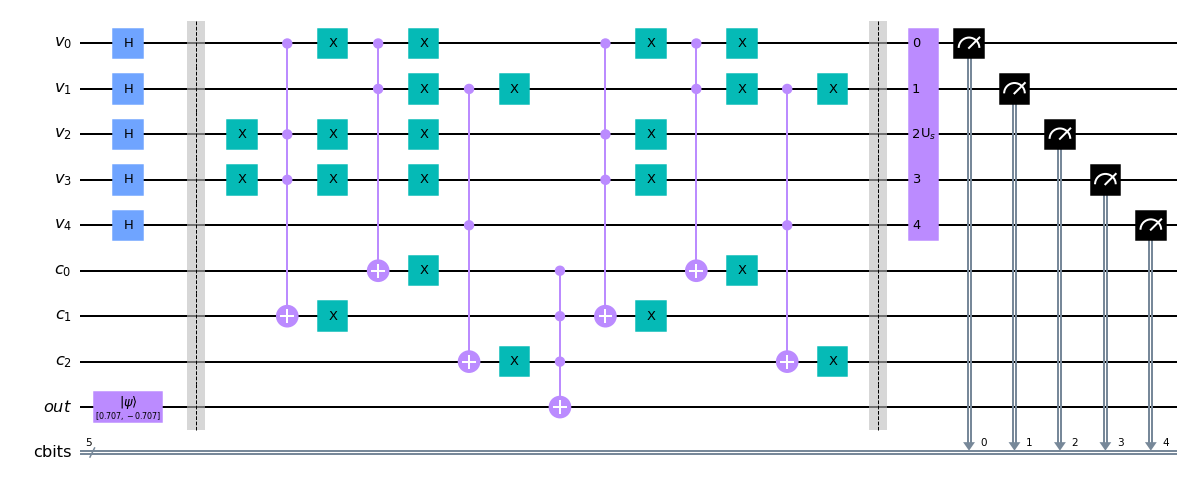

In [44]:
var_qubits = QuantumRegister(5, name='v')
clause_qubits = QuantumRegister(3, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(5, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation
for i in range(1):
    ## First Iteration
    # Apply our oracle
    grover_oracle(qc, clause_qubits)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(5), [0,1,2,3,4])
# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw('mpl',fold=-1)

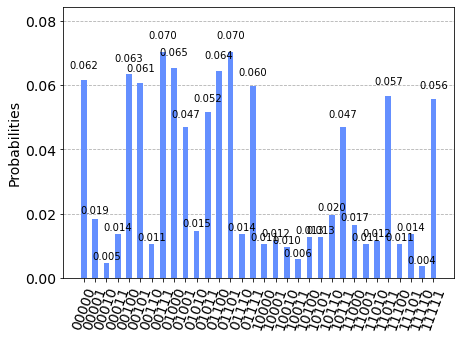

In [45]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())

So as you see, we get 13 solutions to the equation. We only have to do 1 iteration, due to the angles that come out (One angle is $\tan^{-1}\left(\frac{13}{19} \right)$ and that ensures that 1 rotation is sufficient)
